<a href="https://colab.research.google.com/github/ZeynepRuveyda/classification_automi/blob/main/Automated_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Image Classfication 

This notebook has been created to be compatible with any data and to reuse in future image classification use cases. You can see the detail in the workflow chart at the below.




*The MIT License (MIT) Copyright (c) 2022 Automi*

*Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:*

*The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.*

*THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.*

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


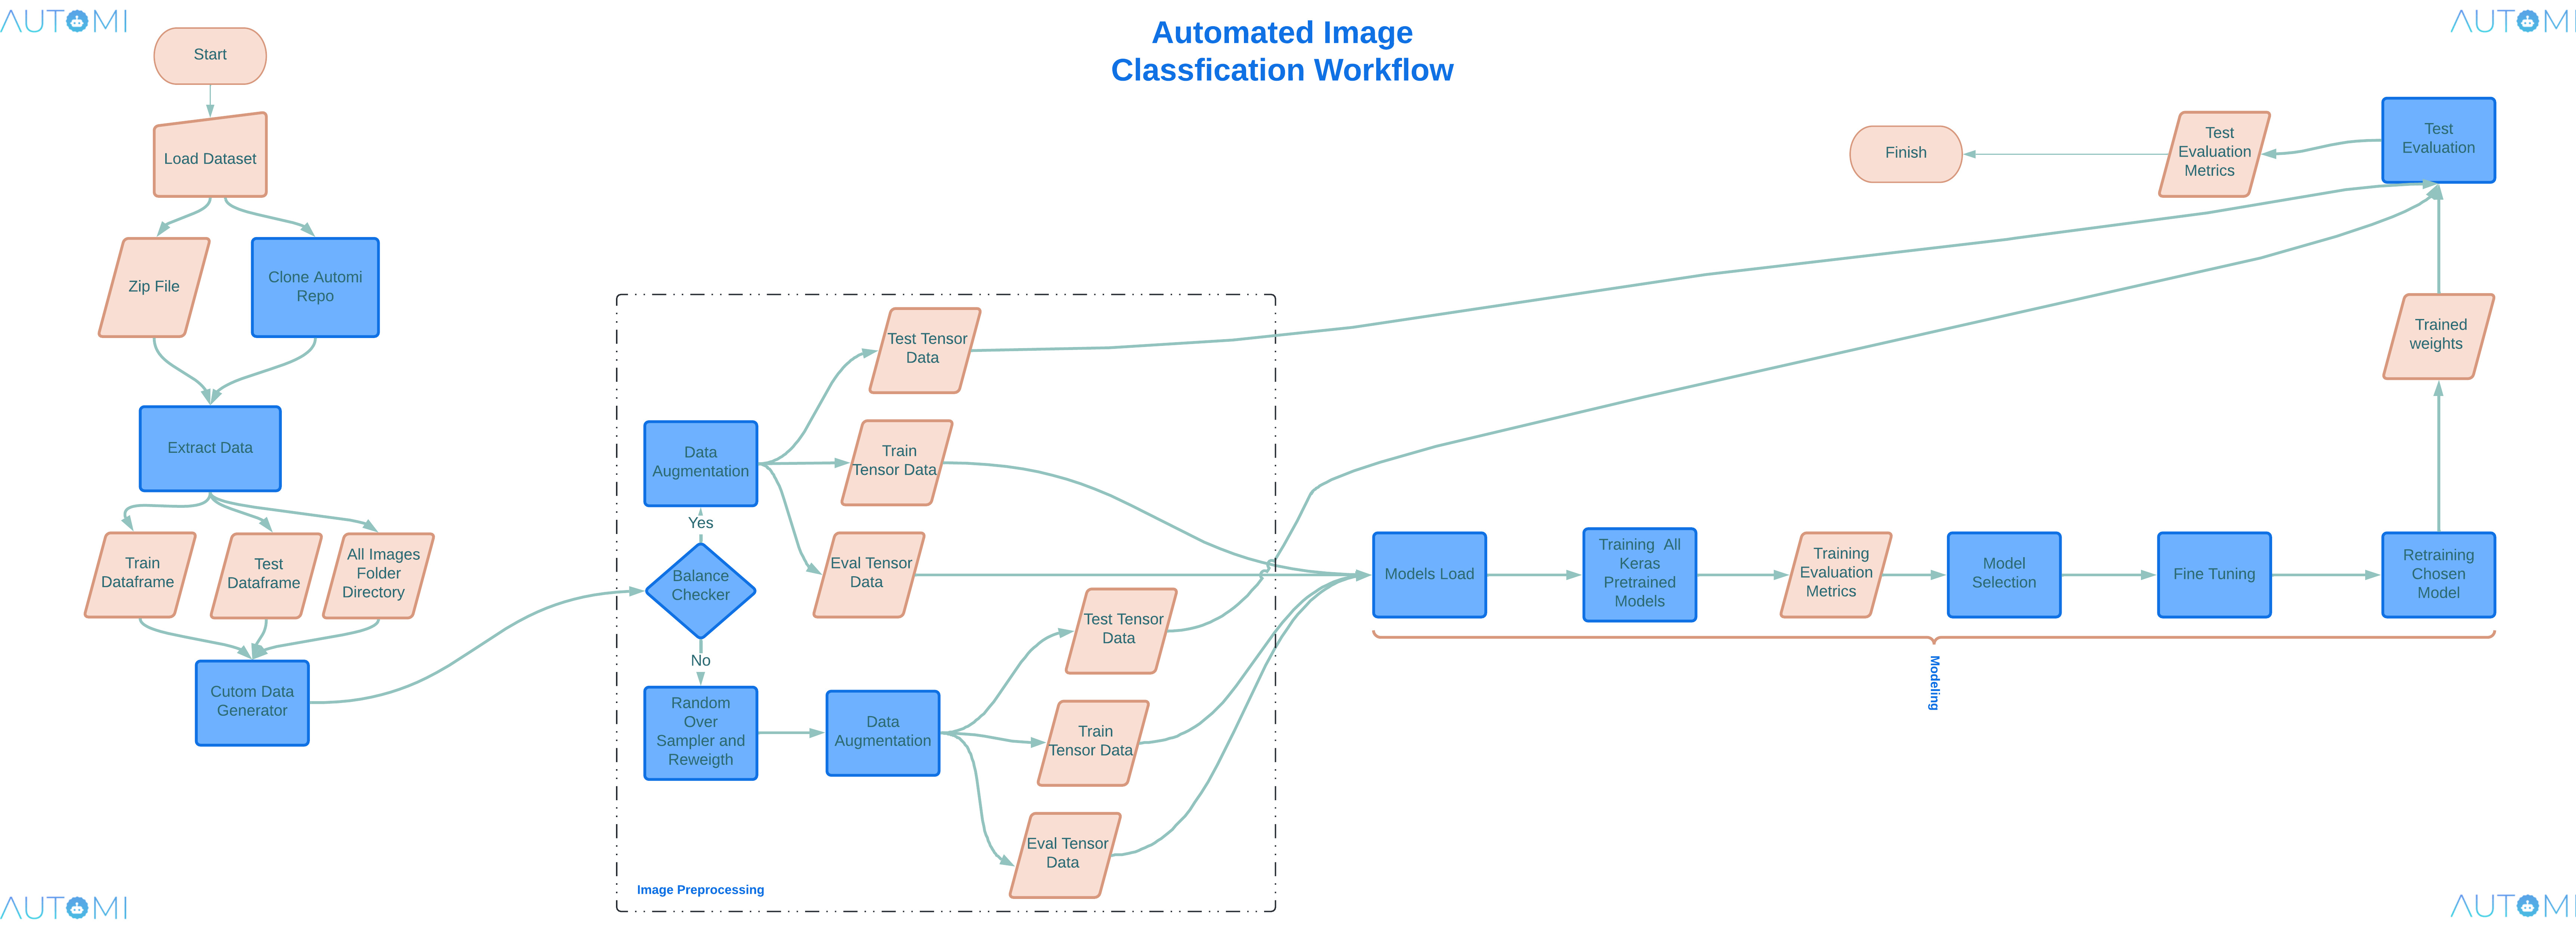

In [ ]:
from IPython.display import Image, display
Image("/content/drive/MyDrive/Automated_Image_Classification/Automated Image Classfication Workflow.jpeg")

## Table of Contents
<ul>
<li><a href="#c">Clone and Import Libraries</a></li>
<li><a href="#dt">Dataset Creating</a></li>
<li><a href="#m">Modeling and Selection</a></li>
<li><a href="#e">Evaluation</a></li>


</ul>

<a id='c'></a>
## Clone and Import Libraries

In [ ]:
# Cloning repositry to get custom classes and function
! git clone https://github.com/ZeynepRuveyda/classification_automi

Cloning into 'classification_automi'...
remote: Enumerating objects: 294, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 294 (delta 186), reused 193 (delta 90), pack-reused 0
Receiving objects: 100% (294/294), 5.46 MiB | 9.22 MiB/s, done.
Resolving deltas: 100% (186/186), done.


In [ ]:
# giving directory
%cd /content/classification_automi

/content/classification_automi


Installing our custom python libraries.

In [ ]:
!python3 utils.py install

In [ ]:
!python3 dataset.py install

In [ ]:
!python3 model.py install

In [ ]:
# Import Custom Libraries
from utils import *
from dataset import *
from model import *
import tensorflow as tf
import json

********************************************************************************

<a id='dt'></a>
## Dataset Creating  and convert from COCO to dataframe

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Automated_Image_Classification/Image/testfor_all_1.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
with open("/content/annotations/instances_default.json") as json_data:
    data = json.load(json_data)

In [ ]:
df_annotations = pd.DataFrame(data['annotations'])

In [ ]:
df_annotations.drop_duplicates(subset='image_id', keep="last",inplace=True)

In [ ]:
labels = []
for column_name,columnData in df_annotations['attributes'].iteritems():
  labels.append(columnData['label'])

In [ ]:
df_images = pd.DataFrame(data['images'])

In [ ]:
df = pd.DataFrame({'id': df_images.file_name.to_list(), 'label': labels})

In [ ]:
df

,id,label
0,DSC_0601.jpg,marking
1,DSC_0602.jpg,marking
2,DSC_0618.jpg,no_marking
3,DSC_0624.jpg,no_marking


# Second dataset and merge

In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/Automated_Image_Classification/Image/bb.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
with open("/content/annotations/instances_default.json") as json_data:
    data = json.load(json_data)

In [ ]:
df_annotations = pd.DataFrame(data['annotations'])

In [ ]:
df_images = pd.DataFrame(data['images'])

In [ ]:
df = pd.DataFrame({'id': df_images.file_name.to_list(), 'label': df_annotations.category_id.to_list()})

In [ ]:
df

,id,label
0,DSC_0601.jpg,1
1,DSC_0602.jpg,1
2,DSC_0618.jpg,2
3,DSC_0624.jpg,2


********************************************************************************

In [ ]:
# Extracting data from zip
train_df,test_df,path_all_images = create_dataset('/content/drive/MyDrive/Automated_Image_Classification/Image/Data.zip')


Found 2 different class folders. If you have more than 2 nm_classes you should split your images as different folders in zip file.


In [ ]:
# train evaluation data splitting
train_df, eval_df = train_test_split(train_df, test_size=0.2)

In [ ]:
# blance checking
balance = balance_check(train_df)

Training data is not balance.


In [ ]:
# find class weigths for balancing
counts = train_df.label.value_counts()
count_dict = counts.to_dict()
nm_classes = len(train_df.label.unique().tolist())
class_weights = create_class_weight(count_dict,nm_classes)

In [ ]:
# random over sampling for balancing
if balance == False :
  print("Class distribution : %s ,Balancing process is started." % (count_dict))
  train_df = random_over_sampling(train_df,path_all_images)
  counts = train_df.label.value_counts()
  count_dict = counts.to_dict()
  print("Class distribution : %s ,Data made balance." % (count_dict))


Class distribution : {'No T': 162, 'T': 57} ,Balancing process is started.
Class distribution : {'No T': 162, 'T': 162} ,Data made balance.


In [ ]:
# Creating custom data generator child from class
custom_data = CustomDataGenerator(path_all_images,test_df,train_df,eval_df,32,(224,224))

In [ ]:
# Checking balance and creating training,eval,test generators, then creating class weights
train_generator,val_generator,test_generator = custom_data.data_generator()

Test Dataset : 
Found 31 validated image filenames belonging to 2 classes.
Validation Dataset : 
Found 55 validated image filenames belonging to 2 classes.
Training Dataset : 
Found 324 validated image filenames belonging to 2 classes.


<a id='m'></a>
## Modeling and Selection

***Do you want see all benchmarking of all classification architectures?*** 
Call benchmarking function and see the result. Then you can choose your final architecture for fine tunning. If you do not want use benchmarking you can directly create model from Custom_Model class then you can apply fine tuning.


*Training all models.

In [ ]:
benchmark_df = model_selection(train_generator,val_generator,(224,224),nm_classes)

  0%|          | 0/34 [00:00<?, ?it/s]

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 15s 764ms/step - loss: 1.0409 - accuracy: 0.5000 - val_loss: 1.4028 - val_accuracy: 0.1818
Epoch 2/3
11/11 [==============================] - 6s 515ms/step - loss: 0.9425 - accuracy: 0.5000 - val_loss: 1.1961 - val_accuracy: 0.1818
Epoch 3/3
11/11 [==============================] - 6s 524ms/step - loss: 0.8424 - accuracy: 0.5000 - val_loss: 1.0346 - val_accuracy: 0.2909


  3%|▎         | 1/34 [00:30<16:39, 30.29s/it]

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 17s 801ms/step - loss: 0.7730 - accuracy: 0.4444 - val_loss: 0.6191 - val_accuracy: 0.7091
Epoch 2/3
11/11 [==============================] - 6s 525ms/step - loss: 0.7149 - accuracy: 0.5463 - val_loss: 0.6177 - val_accuracy: 0.6727
Epoch 3/3
11/11 [==============================] - 6s 533ms/step - loss: 0.6847 - accuracy: 0.5772 - val_loss: 0.6041 - val_accuracy: 0.6909


  6%|▌         | 2/34 [01:04<17:29, 32.78s/it]

74850304/74836368 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 18s 821ms/step - loss: 0.7974 - accuracy: 0.4136 - val_loss: 0.5526 - val_accuracy: 0.7273
Epoch 2/3
11/11 [==============================] - 6s 535ms/step - loss: 0.7388 - accuracy: 0.4321 - val_loss: 0.5286 - val_accuracy: 0.7636
Epoch 3/3
11/11 [==============================] - 6s 526ms/step - loss: 0.6942 - accuracy: 0.5093 - val_loss: 0.5257 - val_accuracy: 0.8000


  9%|▉         | 3/34 [01:42<17:59, 34.83s/it]

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 13s 651ms/step - loss: 0.6950 - accuracy: 0.5000 - val_loss: 0.7234 - val_accuracy: 0.1818
Epoch 2/3
11/11 [==============================] - 6s 521ms/step - loss: 0.6944 - accuracy: 0.5000 - val_loss: 0.7161 - val_accuracy: 0.1818
Epoch 3/3
11/11 [==============================] - 6s 527ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.7157 - val_accuracy: 0.1818


 12%|█▏        | 4/34 [02:10<16:09, 32.30s/it]

27033600/27018416 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 16s 775ms/step - loss: 0.6945 - accuracy: 0.5000 - val_loss: 0.6827 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 516ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6845 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 521ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.8182


 15%|█▍        | 5/34 [02:42<15:31, 32.13s/it]

31801344/31790344 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 16s 734ms/step - loss: 0.6968 - accuracy: 0.5000 - val_loss: 0.6553 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 527ms/step - loss: 0.6950 - accuracy: 0.5000 - val_loss: 0.6685 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 526ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6767 - val_accuracy: 0.8182


 18%|█▊        | 6/34 [03:14<14:57, 32.06s/it]

43950080/43941136 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 16s 807ms/step - loss: 0.7019 - accuracy: 0.5000 - val_loss: 0.6262 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 523ms/step - loss: 0.6985 - accuracy: 0.5000 - val_loss: 0.6477 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 523ms/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6701 - val_accuracy: 0.8182


 21%|██        | 7/34 [03:46<14:30, 32.23s/it]

71696384/71686520 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 19s 821ms/step - loss: 0.6971 - accuracy: 0.5000 - val_loss: 0.7222 - val_accuracy: 0.1818
Epoch 2/3
11/11 [==============================] - 6s 582ms/step - loss: 0.6931 - accuracy: 0.4877 - val_loss: 0.6868 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 530ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6647 - val_accuracy: 0.8182


 24%|██▎       | 8/34 [04:24<14:39, 33.83s/it]

115277824/115263384 [==============================] - 1s 0us/step
Epoch 1/3
11/11 [==============================] - 22s 877ms/step - loss: 0.6951 - accuracy: 0.5000 - val_loss: 0.7010 - val_accuracy: 0.1818
Epoch 2/3
11/11 [==============================] - 6s 535ms/step - loss: 0.6933 - accuracy: 0.4877 - val_loss: 0.6872 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 537ms/step - loss: 0.6941 - accuracy: 0.4938 - val_loss: 0.6873 - val_accuracy: 0.8182


 26%|██▋       | 9/34 [05:05<15:03, 36.15s/it]

165249024/165234480 [==============================] - 1s 0us/step
Epoch 1/3
11/11 [==============================] - 25s 989ms/step - loss: 0.7079 - accuracy: 0.5000 - val_loss: 0.7472 - val_accuracy: 0.1818
Epoch 2/3
11/11 [==============================] - 6s 535ms/step - loss: 0.6947 - accuracy: 0.5000 - val_loss: 0.7017 - val_accuracy: 0.1818
Epoch 3/3
11/11 [==============================] - 6s 530ms/step - loss: 0.6952 - accuracy: 0.4630 - val_loss: 0.6682 - val_accuracy: 0.8182


 29%|██▉       | 10/34 [05:50<15:34, 38.94s/it]

258088960/258076736 [==============================] - 1s 0us/step
Epoch 1/3
11/11 [==============================] - 30s 1s/step - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.7032 - val_accuracy: 0.1818
Epoch 2/3
11/11 [==============================] - 6s 540ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.7061 - val_accuracy: 0.1818
Epoch 3/3
11/11 [==============================] - 6s 533ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.7038 - val_accuracy: 0.1818


 32%|███▏      | 11/34 [06:41<16:22, 42.72s/it]

24289280/24274472 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 13s 686ms/step - loss: 0.6952 - accuracy: 0.4907 - val_loss: 0.6874 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 521ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6852 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 564ms/step - loss: 0.6934 - accuracy: 0.4907 - val_loss: 0.6933 - val_accuracy: 0.5091


 35%|███▌      | 12/34 [07:09<14:01, 38.26s/it]

28467200/28456008 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 16s 724ms/step - loss: 0.6991 - accuracy: 0.5000 - val_loss: 0.7444 - val_accuracy: 0.1818
Epoch 2/3
11/11 [==============================] - 6s 524ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.7078 - val_accuracy: 0.1818
Epoch 3/3
11/11 [==============================] - 6s 525ms/step - loss: 0.6933 - accuracy: 0.4877 - val_loss: 0.6912 - val_accuracy: 0.8182


 38%|███▊      | 13/34 [07:42<12:44, 36.41s/it]

35848192/35839040 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 15s 732ms/step - loss: 0.7004 - accuracy: 0.4352 - val_loss: 0.6879 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 523ms/step - loss: 0.6959 - accuracy: 0.4877 - val_loss: 0.6928 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 529ms/step - loss: 0.6934 - accuracy: 0.5802 - val_loss: 0.6967 - val_accuracy: 0.1818


 41%|████      | 14/34 [08:12<11:34, 34.70s/it]

52617216/52606240 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 17s 756ms/step - loss: 0.7046 - accuracy: 0.5000 - val_loss: 0.6866 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 518ms/step - loss: 0.6969 - accuracy: 0.5000 - val_loss: 0.6825 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 531ms/step - loss: 0.6941 - accuracy: 0.5000 - val_loss: 0.6880 - val_accuracy: 0.8182


 44%|████▍     | 15/34 [08:45<10:48, 34.13s/it]

473186304/473176280 [==============================] - 3s 0us/step
Epoch 1/3
11/11 [==============================] - 34s 1s/step - loss: 0.6940 - accuracy: 0.4475 - val_loss: 0.6867 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 544ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6882 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 542ms/step - loss: 0.6932 - accuracy: 0.4877 - val_loss: 0.6890 - val_accuracy: 0.8000


 47%|████▋     | 16/34 [09:46<12:38, 42.12s/it]

214212608/214201816 [==============================] - 1s 0us/step
Epoch 1/3
11/11 [==============================] - 27s 963ms/step - loss: 0.6955 - accuracy: 0.5000 - val_loss: 0.6404 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 531ms/step - loss: 0.6950 - accuracy: 0.5000 - val_loss: 0.6445 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 528ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6500 - val_accuracy: 0.8182


 50%|█████     | 17/34 [10:33<12:24, 43.78s/it]

82436096/82420632 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 19s 810ms/step - loss: 0.7050 - accuracy: 0.2438 - val_loss: 0.6832 - val_accuracy: 0.6545
Epoch 2/3
11/11 [==============================] - 6s 530ms/step - loss: 0.6940 - accuracy: 0.4568 - val_loss: 0.6672 - val_accuracy: 0.7818
Epoch 3/3
11/11 [==============================] - 6s 530ms/step - loss: 0.6908 - accuracy: 0.4907 - val_loss: 0.6507 - val_accuracy: 0.8000


 53%|█████▎    | 18/34 [11:10<11:06, 41.66s/it]

Epoch 1/3
11/11 [==============================] - 21s 860ms/step - loss: 0.9215 - accuracy: 0.2006 - val_loss: 0.8913 - val_accuracy: 0.1818
Epoch 2/3
11/11 [==============================] - 6s 527ms/step - loss: 0.8455 - accuracy: 0.2500 - val_loss: 0.7999 - val_accuracy: 0.3091
Epoch 3/3
11/11 [==============================] - 6s 523ms/step - loss: 0.7571 - accuracy: 0.3765 - val_loss: 0.7795 - val_accuracy: 0.3818


 56%|█████▌    | 19/34 [11:50<10:15, 41.03s/it]

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/3
11/11 [==============================] - 11s 665ms/step - loss: 0.6123 - accuracy: 0.7253 - val_loss: 0.6044 - val_accuracy: 0.7636
Epoch 2/3
11/11 [==============================] - 6s 525ms/step - loss: 0.5127 - accuracy: 0.9228 - val_loss: 0.4592 - val_accuracy: 0.9273
Epoch 3/3
11/11 [==============================] - 6s 565ms/step - loss: 0.4600 - accuracy: 0.9290 - val_loss: 0.4091 - val_accuracy: 0.9455


 59%|█████▉    | 20/34 [12:17<08:37, 36.98s/it]

17235968/17225924 [==============================] - 1s 0us/step
Epoch 1/3
11/11 [==============================] - 8s 589ms/step - loss: 0.8363 - accuracy: 0.5093 - val_loss: 0.9457 - val_accuracy: 0.2909
Epoch 2/3
11/11 [==============================] - 6s 525ms/step - loss: 0.7397 - accuracy: 0.5648 - val_loss: 0.7724 - val_accuracy: 0.5091
Epoch 3/3
11/11 [==============================] - 6s 521ms/step - loss: 0.6674 - accuracy: 0.6883 - val_loss: 0.6651 - val_accuracy: 0.6909


 62%|██████▏   | 21/34 [12:39<07:02, 32.53s/it]

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 9s 663ms/step - loss: 0.7809 - accuracy: 0.6852 - val_loss: 0.7870 - val_accuracy: 0.5091
Epoch 2/3
11/11 [==============================] - 6s 519ms/step - loss: 0.6787 - accuracy: 0.7130 - val_loss: 0.6789 - val_accuracy: 0.5636
Epoch 3/3
11/11 [==============================] - 6s 520ms/step - loss: 0.6117 - accuracy: 0.7654 - val_loss: 0.6011 - val_accuracy: 0.6727


 65%|██████▍   | 22/34 [13:02<05:54, 29.58s/it]

12697600/12683000 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 10s 629ms/step - loss: 0.7860 - accuracy: 0.5000 - val_loss: 0.5153 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 513ms/step - loss: 0.7715 - accuracy: 0.5000 - val_loss: 0.5242 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 512ms/step - loss: 0.7596 - accuracy: 0.5000 - val_loss: 0.5339 - val_accuracy: 0.8182


 68%|██████▊   | 23/34 [13:27<05:08, 28.04s/it]

4349952/4334752 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 10s 616ms/step - loss: 0.7400 - accuracy: 0.5000 - val_loss: 0.7692 - val_accuracy: 0.1818
Epoch 2/3
11/11 [==============================] - 6s 561ms/step - loss: 0.7298 - accuracy: 0.5000 - val_loss: 0.7587 - val_accuracy: 0.1818
Epoch 3/3
11/11 [==============================] - 6s 513ms/step - loss: 0.7218 - accuracy: 0.5000 - val_loss: 0.7494 - val_accuracy: 0.1818


 71%|███████   | 24/34 [13:50<04:25, 26.51s/it]

20004864/19993432 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 21s 908ms/step - loss: 0.6843 - accuracy: 0.5278 - val_loss: 0.6524 - val_accuracy: 0.5636
Epoch 2/3
11/11 [==============================] - 6s 571ms/step - loss: 0.6639 - accuracy: 0.5802 - val_loss: 0.6519 - val_accuracy: 0.6182
Epoch 3/3
11/11 [==============================] - 6s 521ms/step - loss: 0.6291 - accuracy: 0.6975 - val_loss: 0.6407 - val_accuracy: 0.6364


 74%|███████▎  | 25/34 [14:32<04:41, 31.32s/it]

171458560/171446536 [==============================] - 1s 0us/step
Epoch 1/3
11/11 [==============================] - 15s 736ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6666 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 518ms/step - loss: 0.6920 - accuracy: 0.5000 - val_loss: 0.6659 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 522ms/step - loss: 0.6917 - accuracy: 0.5000 - val_loss: 0.6629 - val_accuracy: 0.8182


 76%|███████▋  | 26/34 [15:03<04:09, 31.19s/it]

171327488/171317808 [==============================] - 1s 0us/step
Epoch 1/3
11/11 [==============================] - 13s 710ms/step - loss: 1.0531 - accuracy: 0.3580 - val_loss: 0.7236 - val_accuracy: 0.5818
Epoch 2/3
11/11 [==============================] - 6s 521ms/step - loss: 0.8803 - accuracy: 0.4043 - val_loss: 0.7049 - val_accuracy: 0.6182
Epoch 3/3
11/11 [==============================] - 6s 520ms/step - loss: 0.7824 - accuracy: 0.5031 - val_loss: 0.6687 - val_accuracy: 0.6545


 79%|███████▉  | 27/34 [15:33<03:35, 30.80s/it]

234708992/234698864 [==============================] - 2s 0us/step
Epoch 1/3
11/11 [==============================] - 16s 794ms/step - loss: 0.7140 - accuracy: 0.5000 - val_loss: 0.6530 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 526ms/step - loss: 0.7024 - accuracy: 0.5000 - val_loss: 0.6560 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 526ms/step - loss: 0.6960 - accuracy: 0.5000 - val_loss: 0.6582 - val_accuracy: 0.8182


 82%|████████▏ | 28/34 [16:09<03:14, 32.47s/it]

234561536/234545216 [==============================] - 2s 0us/step
Epoch 1/3
11/11 [==============================] - 17s 772ms/step - loss: 0.8725 - accuracy: 0.4012 - val_loss: 0.8318 - val_accuracy: 0.4909
Epoch 2/3
11/11 [==============================] - 6s 527ms/step - loss: 0.7721 - accuracy: 0.5216 - val_loss: 0.7031 - val_accuracy: 0.6182
Epoch 3/3
11/11 [==============================] - 6s 526ms/step - loss: 0.6747 - accuracy: 0.6389 - val_loss: 0.6042 - val_accuracy: 0.7636


 85%|████████▌ | 29/34 [16:46<02:48, 33.79s/it]

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/3
11/11 [==============================] - 10s 629ms/step - loss: 0.7320 - accuracy: 0.5000 - val_loss: 0.8500 - val_accuracy: 0.1818
Epoch 2/3
11/11 [==============================] - 6s 515ms/step - loss: 0.7125 - accuracy: 0.5000 - val_loss: 0.7881 - val_accuracy: 0.1818
Epoch 3/3
11/11 [==============================] - 6s 507ms/step - loss: 0.7023 - accuracy: 0.5000 - val_loss: 0.7489 - val_accuracy: 0.1818


 88%|████████▊ | 30/34 [17:11<02:04, 31.05s/it]

94683136/94668760 [==============================] - 2s 0us/step
Epoch 1/3
11/11 [==============================] - 9s 601ms/step - loss: 0.6182 - accuracy: 0.7716 - val_loss: 0.6559 - val_accuracy: 0.7818
Epoch 2/3
11/11 [==============================] - 6s 510ms/step - loss: 0.5414 - accuracy: 0.8735 - val_loss: 0.5752 - val_accuracy: 0.8909
Epoch 3/3
11/11 [==============================] - 6s 516ms/step - loss: 0.4710 - accuracy: 0.9321 - val_loss: 0.5187 - val_accuracy: 0.9636


 91%|█████████ | 31/34 [17:36<01:27, 29.22s/it]

58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 8s 672ms/step - loss: 0.7466 - accuracy: 0.4969 - val_loss: 0.6560 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 509ms/step - loss: 0.7337 - accuracy: 0.4938 - val_loss: 0.6499 - val_accuracy: 0.8182
Epoch 3/3
11/11 [==============================] - 6s 515ms/step - loss: 0.7297 - accuracy: 0.4969 - val_loss: 0.6454 - val_accuracy: 0.8182


 94%|█████████▍| 32/34 [17:56<00:53, 26.56s/it]

80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/3
11/11 [==============================] - 7s 570ms/step - loss: 0.6969 - accuracy: 0.5000 - val_loss: 0.6709 - val_accuracy: 0.8182
Epoch 2/3
11/11 [==============================] - 6s 525ms/step - loss: 0.6939 - accuracy: 0.4877 - val_loss: 0.6757 - val_accuracy: 0.8000
Epoch 3/3
11/11 [==============================] - 6s 516ms/step - loss: 0.6912 - accuracy: 0.4815 - val_loss: 0.6755 - val_accuracy: 0.8000


 97%|█████████▋| 33/34 [18:16<00:24, 24.68s/it]

83697664/83683744 [==============================] - 0s 0us/step
Epoch 1/3
11/11 [==============================] - 9s 611ms/step - loss: 0.6708 - accuracy: 0.6296 - val_loss: 0.6630 - val_accuracy: 0.7091
Epoch 2/3
11/11 [==============================] - 6s 515ms/step - loss: 0.6180 - accuracy: 0.8519 - val_loss: 0.6096 - val_accuracy: 0.8545
Epoch 3/3
11/11 [==============================] - 6s 517ms/step - loss: 0.5825 - accuracy: 0.9136 - val_loss: 0.5621 - val_accuracy: 0.9273


100%|██████████| 34/34 [18:41<00:00, 32.99s/it]


In [ ]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(benchmark_df)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('benchmark_df.csv', index=False) # write results to csv file
benchmark_df_sorted = benchmark_df.sort_values(["validation_accuracy"], ascending=False)
benchmark_df_sorted

,model_name,num_model_params,validation_accuracy
30,ResNet50V2,23568898,0.963636
19,InceptionV3,21806882,0.945455
33,Xception,20865578,0.927273
5,EfficientNetB2,7771387,0.818182
7,EfficientNetB4,17677409,0.818182
31,VGG16,14715714,0.818182
14,EfficientNetV2B3,12933696,0.818182
6,EfficientNetB3,10786609,0.818182
8,EfficientNetB5,28517625,0.818182
12,EfficientNetV2B1,6933686,0.818182


## Working Specific Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Custom_Model('ResNet50V2',(224,224),nm_classes)

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
model = model.forward()

In [ ]:
earlystopping = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=20,min_delta=0.001)

checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Automated_Image_Classification/first_training.hdf5", verbose=1, save_best_only=True)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 54,339,810
Trainable params: 3,074
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
history = model.fit(train_generator,epochs=10,validation_data=val_generator,class_weight=class_weights, callbacks=[checkpointer, earlystopping])

Epoch 1/10
11/11 [==============================] - ETA: 0s - loss: 0.7816 - accuracy: 0.5123
Epoch 1: val_loss improved from inf to 0.94587, saving model to /content/drive/MyDrive/Automated_Image_Classification/first_training.hdf5
11/11 [==============================] - 28s 750ms/step - loss: 0.7816 - accuracy: 0.5123 - val_loss: 0.9459 - val_accuracy: 0.1818
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.5278
Epoch 2: val_loss improved from 0.94587 to 0.94512, saving model to /content/drive/MyDrive/Automated_Image_Classification/first_training.hdf5
11/11 [==============================] - 8s 676ms/step - loss: 0.6956 - accuracy: 0.5278 - val_loss: 0.9451 - val_accuracy: 0.1818
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.5309
Epoch 3: val_loss improved from 0.94512 to 0.89037, saving model to /content/drive/MyDrive/Automated_Image_Classification/first_training.hdf5
11/11 [==========================

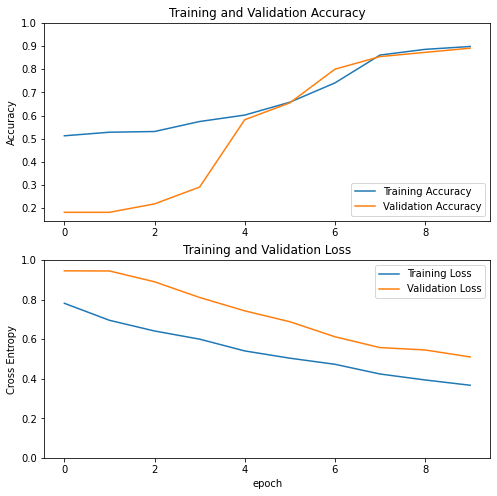

In [ ]:
metrics_visualization(history)

## Evaluation and Prediction


In [ ]:
y_true = test_generator.classes
predict = model.predict_generator(test_generator)
y_pred = np.argmax(predict, axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Legitimate Transactions Detected (True Negatives):  19
Legitimate Transactions Incorrectly Detected (False Positives):  3
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  9
Total Fraudulent Transactions:  9
_______________________________________________________________________
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        22
           1       0.75      1.00      0.86         9

    accuracy                           0.90        31
   macro avg       0.88      0.93      0.89        31
weighted avg       0.93      0.90      0.91        31



<function matplotlib.pyplot.show>

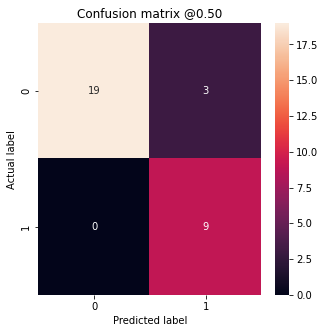

In [ ]:
# plotting confusion matrix and classfication report
plot_cm(y_true,y_pred)